In [1]:
import os
from skimage import io
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from tensorflow import keras

from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
import tensorflow as tf
#tf.config.gpu.set_per_process_memory_fraction(0.75)
#tf.config.gpu.set_per_process_memory_growth(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [6]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 20
l = 7 # no of layers in dense block
num_filter = 30  # growth rate k
compression = 1
dropout_rate = 0.2

In [7]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
#x_train = tf.cast(X_train, dtype=tf.float32)
#x_test = tf.cast(X_test, dtype=tf.float32)


#tf.dtypes.cast(X_train,tf.int32, name=x_train)
#tf.dtypes.cast(X_test,tf.int32, name=x_test)


# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 3s 0us/step


In [8]:
import pandas as pd
import numpy as np
'''def preprocess_data(data_set):
    mean = np.array([125.3, 123.0, 113.9])
    std = np.array([63.0, 62.1, 66.7])

    data_set -= mean
    data_set /= std
    return data_set

x_train = preprocess_data(x_train)
x_test = preprocess_data(x_test)'''


x_train /= 255
x_test /= 255

In [9]:
x_train.shape

(50000, 32, 32, 3)

In [10]:
x_test.shape

(10000, 32, 32, 3)

In [11]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, DepthwiseConv2D
from keras.layers import Concatenate
from keras.models import load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.10)


In [12]:
# Data augementation
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.10
)

datagen_train.fit(x_train)

'''train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      shear_range=0.3,
      zoom_range=0.1,
      width_shift_range=0.125,
      height_shift_range=0.125,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
        x_train,y_train,
        batch_size=batch_size,
        shuffle=True)
 
validation_generator = validation_datagen.flow(
        x_val,y_val,
        batch_size=batch_size,
        shuffle=True)
#datagen_train.fit(x_train)'''

"train_datagen = ImageDataGenerator(\n      rescale=1./255,\n      rotation_range=20,\n      shear_range=0.3,\n      zoom_range=0.1,\n      width_shift_range=0.125,\n      height_shift_range=0.125,\n      horizontal_flip=True,\n      fill_mode='nearest')\nvalidation_datagen = ImageDataGenerator(rescale=1./255)\n\ntrain_generator = train_datagen.flow(\n        x_train,y_train,\n        batch_size=batch_size,\n        shuffle=True)\n \nvalidation_generator = validation_datagen.flow(\n        x_val,y_val,\n        batch_size=batch_size,\n        shuffle=True)\n#datagen_train.fit(x_train)"

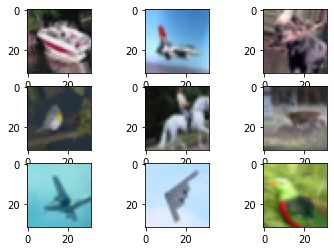

In [13]:
for X_batch, y_batch in datagen_train.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
    plt.show()
    break

In [14]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Block
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [ ]:
#num_filter = 12
#dropout_rate = 0.2
#l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


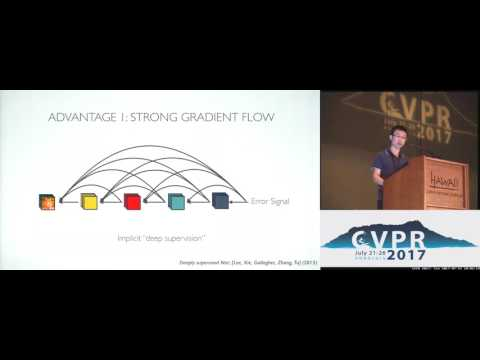

In [ ]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 30)   810         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 30)   120         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 30)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',#SGD(lr=0.1, momentum=0.9, decay=0.0001, nesterov=True),
              metrics=['accuracy'])

In [ ]:
'''reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.000001)

early_stop = EarlyStopping(monitor = "val_loss", patience = 10)
def decay_fn(epoch, lr):
    if epoch < 50:
        return 0.001
    elif epoch >= 50 and epoch < 75:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)

csv_logger = CSVLogger('training.log')
filepath = "{epoch:03d}-{val_acc:.3f}.hdf5"
model_chkpt = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only=True, verbose = 1)'''

'reduce_lr = ReduceLROnPlateau(monitor = \'val_loss\', factor = 0.1, patience = 5, min_lr = 0.000001)\n\nearly_stop = EarlyStopping(monitor = "val_loss", patience = 10)\ndef decay_fn(epoch, lr):\n    if epoch < 50:\n        return 0.001\n    elif epoch >= 50 and epoch < 75:\n        return 0.0001\n    else:\n        return 0.00001\n\nlr_scheduler = LearningRateScheduler(decay_fn)\n\ncsv_logger = CSVLogger(\'training.log\')\nfilepath = "{epoch:03d}-{val_acc:.3f}.hdf5"\nmodel_chkpt = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only=True, verbose = 1)'

In [ ]:
%%time
history = model.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=(len(x_train)/batch_size)*5,
    epochs=epochs,
    verbose = 1,
    validation_data=(x_val, y_val),
    #callbacks = [lr_scheduler, csv_logger, model_chkpt]
)


Epoch 1/20
3516/3515 [==============================] - 819s 233ms/step - loss: 1.0965 - acc: 0.6052 - val_loss: 0.9847 - val_acc: 0.6976
Epoch 2/20
3516/3515 [==============================] - 805s 229ms/step - loss: 0.6824 - acc: 0.7612 - val_loss: 0.8113 - val_acc: 0.7600
Epoch 3/20
3516/3515 [==============================] - 805s 229ms/step - loss: 0.5546 - acc: 0.8075 - val_loss: 0.8002 - val_acc: 0.7836
Epoch 4/20
3516/3515 [==============================] - 805s 229ms/step - loss: 0.4844 - acc: 0.8322 - val_loss: 0.5801 - val_acc: 0.8254
Epoch 5/20
3516/3515 [==============================] - 808s 230ms/step - loss: 0.4302 - acc: 0.8503 - val_loss: 0.5544 - val_acc: 0.8374
Epoch 6/20
3516/3515 [==============================] - 807s 230ms/step - loss: 0.3908 - acc: 0.8637 - val_loss: 0.4420 - val_acc: 0.8712
Epoch 7/20
3516/3515 [==============================] - 805s 229ms/step - loss: 0.3607 - acc: 0.8742 - val_loss: 0.4671 - val_acc: 0.8590
Epoch 8/20
3516/3515 [============

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 30)   810         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 30)   120         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 30)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 9s 950us/sample - loss: 0.3658 - acc: 0.8987
Test loss: 0.3657665253818035
Test accuracy: 0.8987


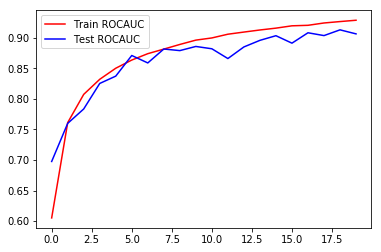

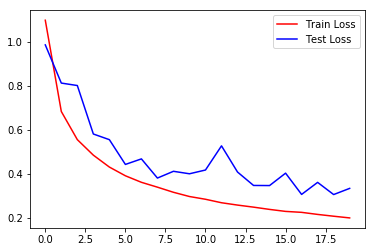

In [ ]:
plt.plot(history.history['acc'], 'r')
plt.plot(history.history['val_acc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()


plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

Here train and test AUC as well as loss value are very near >90% . TheAUC achieve more than 90& with just 20 epochs. overfitting chance is very low

In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


# CNN on CIFR Assignment:

In [15]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense,AveragePooling2D,BatchNormalization,Conv2D,Input,Flatten,Activation,concatenate,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [16]:
# Hyperparameters
batch_size = 64
num_classes = 10
num_filter = 12
compression = 0.5

In [17]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=10/50, random_state=42)

In [19]:

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_cv = tf.keras.utils.to_categorical(y_cv, num_classes)

In [20]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_cv.shape,y_cv.shape)

(40000, 32, 32, 3) (40000, 10)
(10000, 32, 32, 3) (10000, 10)
(10000, 32, 32, 3) (10000, 10)


##### Model Architechture

Implemented DenseNet-BC(k= 12, L = 100) with 0.76M parameters with cifar-10 using augmentation.

In [21]:
class Convolution():
    '''
    Before entering the first dense vlock, a convolution with 16 (or twice the 
    growth rate for BC type) output channels is performed on the input images
    '''
    def __init__(self, growthRate = 12, weight_decay=1E-4):
        self.growthRate = growthRate
        self.weight_decay = weight_decay
        
    def __call__(self, x):
        
        #x = Activation('relu')(x)
        op = Conv2D(int(2*self.growthRate),3,padding="same",use_bias=False,bias_initializer='zeros',kernel_regularizer=l2(self.weight_decay))(x)
        
        return op

In [22]:
# test code
in_ = Input(shape=(32,32,3))
op = Convolution()(in_)
print(op.shape)

(None, 32, 32, 24)


In [24]:
class Bottelneck():
    """
    This class implements H(l) as mentioned in paper.
    BN-ReLU-Conv(1x1)-BN-ReLU-Conv(3x3) version of H.
    """
    
    def __init__(self,growthrate = 12,weight_decay=1E-4):
        
        self.growthrate = growthrate
        self.weight_decay = weight_decay
        
        
    def __call__(self,x):
        """
        This is where logic lives.
        """
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = Activation("relu")(x)
        x = Conv2D(int(4*self.growthrate),1,padding="same",use_bias=False,kernel_initializer="he_uniform",kernel_regularizer=l2(self.weight_decay))(x)
        
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = Activation("relu")(x)
        x = Conv2D(int(self.growthrate),3,padding="same",use_bias=False,kernel_initializer="he_uniform",kernel_regularizer=l2(self.weight_decay))(x)
        
        return x

In [25]:
class Transition():
    """
    This class implements transition layer as per paper.
    BN-Con-pooling
    """  
    def __init__(self,compression = 0.5,growthrate = 12,weight_decay=1E-4):
        
        self.compression = compression
        self.growthrate = growthrate
        self.weight_decay = weight_decay
        
    def __call__(self,x):
        
        nChannels = x.shape.as_list()[-1]
        
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = Activation("relu")(x)
        x = Conv2D(int(self.compression * nChannels),1,padding="same",use_bias=False,kernel_regularizer=l2(self.weight_decay))(x)
        x = AveragePooling2D(pool_size=(2,2))(x)
        
        return x

In [26]:
class Densenet():
    """
    This layer implements densenet.
    """
    def __init__(self,depth,growthrate = 12,bottleneck = True):
        
        nDenseLayers = (depth-4) // 3
        if bottleneck:
            nDenseLayers //= 2
        
        self.nDenseLayers = nDenseLayers
        self.growthrate = growthrate
        
            
    def __call__(self,x):
        
        # Dense Block logic
        
        # convolution block
        x = Convolution()(x)
        
        # 1st dense block
        layers = []
        for i in range(int(self.nDenseLayers)):
            bt = Bottelneck()(x)
            x = concatenate([x,bt])
            
        # transition layer
        x = Transition()(x)
            
        # 2nd dense block
        layers = []
        for i in range(int(self.nDenseLayers)):
            bt = Bottelneck()(x)
            x = concatenate([x,bt])
            
        # transition layer
        x = Transition()(x)

        # 3rd dense block
        layers = []
        for i in range(int(self.nDenseLayers)):
            bt = Bottelneck()(x)
            x = concatenate([x,bt])

        return x

In [27]:
class Output():
    """
    This layer implements output layer.
    """
    
    def __init__(self,num_classes = 10,weight_decay=1E-4):
        
        self.num_classes = num_classes
        self.weight_decay = weight_decay
        
    def __call__(self,x):
      
        x = BatchNormalization(beta_regularizer=l2(self.weight_decay),gamma_regularizer=l2(self.weight_decay))(x)
        x = GlobalAveragePooling2D()(x)
        #avg = AveragePooling2D(pool_size=(8,8))(x)
        #flt = Flatten()(avg)
        op = Dense(self.num_classes,activation="softmax",kernel_regularizer=l2(self.weight_decay), bias_regularizer=l2(self.weight_decay))(x)
        
        return op

#### Model building

In [28]:
# # The DenseNet used in our experiments has three dense blocks that each has an equal number of layers.

# 

# # First convolution
# cnv = Convolution()(in_)

# # For dense block  1
# op = Densenet(depth=100)(cnv)
# op = Transition()(op)

# # For dense block  2
# op = Densenet(depth=100)(op)
# op = Transition()(op)


in_ = Input(shape=(32,32,3))

# densenet
op = Densenet(100)(in_)

# output 
op = Output()(op)

In [29]:
model = Model(inputs = in_,outputs = op)
sgd = tf.keras.optimizers.SGD(lr = 0.1,momentum = 0.9,nesterov = True)
model.compile(sgd,loss="categorical_crossentropy",metrics=["acc"])

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [31]:
#callbacks
from time import time
from datetime import datetime


from tensorflow.python.keras.callbacks import TensorBoard

filepath = "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
history = tf.keras.callbacks.History()

# tensorboard
tensorboard = TensorBoard(log_dir="model_logs/{}".format(time()))

filepath = "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
checkpoint_save = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint_save,learning_rate_reduction,history]#,tensorboard]

In [32]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    zoom_range=0.3,
    rotation_range=15,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='nearest')

cv_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen.fit(X_train)
cv_datagen.fit(X_cv)
test_datagen.fit(X_test)

In [33]:
# # # using tensorboard instance for callbacks
# from time import time
# from datetime import datetime
# from tensorflow.python.keras.callbacks import TensorBoard

# filepath = "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
# history = tf.keras.callbacks.History()

# # # tensorboard
# tensorboard = TensorBoard(log_dir="model_logs/{}".format(time()))

# # # best model saving
# model_check = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# # # reduce learning rate
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=0.0001)

In [34]:
epochs = 100
batch_size = 64
val_batch_size = 64
steps = len(y_train)//batch_size
val_steps = len(y_cv)//val_batch_size

In [35]:
model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=64),steps_per_epoch=steps,
                    epochs=100,callbacks=callbacks_list,
                    validation_data=cv_datagen.flow(X_cv,y_cv,batch_size=64),validation_steps = val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 3.2553 - acc: 0.4124
Epoch 00001: val_acc improved from -inf to 0.48438, saving model to weights.01-2.98.hdf5
625/625 [==============================] - 129s 207ms/step - loss: 3.2553 - acc: 0.4124 - val_loss: 2.9768 - val_acc: 0.4844 - lr: 0.1000
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 2.4735 - acc: 0.5886
Epoch 00002: val_acc improved from 0.48438 to 0.61348, saving model to weights.02-2.30.hdf5
625/625 [==============================] - 127s 204ms/step - loss: 2.4735 - acc: 0.5886 - val_loss: 2.3014 - val_acc: 0.6135 - lr: 0.1000
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 2.0095 - acc: 0.6750
Epoch 00003: val_acc improved from 0.61348 to 0.64694, saving model to weights.03-2.01.hdf5
625/625 [==============================] - 126s 202ms/step - loss: 2.0095 - acc: 0.6750 - val_loss:

In [36]:
# evaluate on test data
score = model.evaluate_generator(test_datagen.flow(X_test, y_test, batch_size=64), verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
157/157 [==============================] - 7s 47ms/step - loss: 0.4318 - acc: 0.9287


In [37]:

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4318452775478363
Test accuracy: 0.9286999702453613


In [43]:
# Save the trained weights in to .h5 format
model.save_weights("CNN_model.h5")
print("Saved model to disk")

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
%matplotlib inline
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:

import numpy as np
# Predict the values from the validation dataset
X_test = X_test.astype('float32')
X_test /= 255

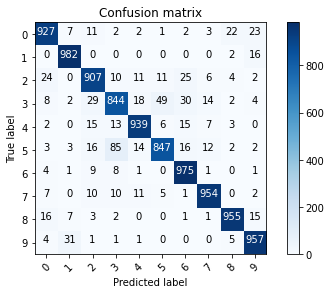

In [40]:
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))